# Part III: Time-Series Forecasting using RNNs [20 pts]


## Step 1: Data exploration and preprocessing

1. To load my dataset & To print the following statistics & Introduction about the dataset

- Dataset description -> The AirQualityUCI dataset contains hourly averaged responses from a chemical sensor system deployed in an Italian city. In the original file, -200 indicates missing or invalid readings. Measurements were tried from sensor device to monitor air pollution levels like carbon monoxide and other chemical compounds.
- Dataset link: https://archive.ics.uci.edu/dataset/360/air+quality
- Number of samples (time points)
- Number of features
- Mean, standard deviation, minimum, and maximum values for each feature (or relevant descriptive statistics depending on the data type)

In [271]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import seaborn as sns
from torchinfo import summary
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.tensorboard.writer import SummaryWriter

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is used!!!")
else:
    device = torch.device("cpu")
    print("CPU is used!!!")

file_path = 'AirQualityUCI.csv'
df = pd.read_csv(file_path, sep = ';', decimal = ',')

num_samples = len(df)
num_features = len(df.columns)
print(f"Number of samples rows: {num_samples}")
print(f"Number of features columns: {num_features}")

print("\nSummary statistics of numeric columns")
print(df.describe(include=[np.number]))


MPS is used!!!
Number of samples rows: 9471
Number of features columns: 17

Summary statistics of numeric columns
            CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9357.000000  9357.000000  9357.000000  9357.000000    9357.000000   
mean    -34.207524  1048.990061  -159.090093     1.865683     894.595276   
std      77.657170   329.832710   139.789093    41.380206     342.333252   
min    -200.000000  -200.000000  -200.000000  -200.000000    -200.000000   
25%       0.600000   921.000000  -200.000000     4.000000     711.000000   
50%       1.500000  1053.000000  -200.000000     7.900000     895.000000   
75%       2.600000  1221.000000  -200.000000    13.600000    1105.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9357.000000   9357.000000  9357.000000   9357.000000  9357.000000   
mean    168.616971    794.990168    58.148873   1

2. Identify any missing values.

- I can recognize the missing values after importing AirQualityUCI.csv by ussing Pandas.
- It has just 1.2% null values in each column.

In [272]:
missing_values = df.isnull().sum()
print(missing_values)

missing_percentage = df.isnull().mean() * 100
print(missing_percentage)
print(len(df))

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64
Date               1.203674
Time               1.203674
CO(GT)             1.203674
PT08.S1(CO)        1.203674
NMHC(GT)           1.203674
C6H6(GT)           1.203674
PT08.S2(NMHC)      1.203674
NOx(GT)            1.203674
PT08.S3(NOx)       1.203674
NO2(GT)            1.203674
PT08.S4(NO2)       1.203674
PT08.S5(O3)        1.203674
T                  1.203674
RH                 1.203674
AH                 1.203674
Unnamed: 15      100.000000
Unnamed: 16      100.000000
dtype: float64
9471


3. Handle any missing values (imputation or removal).

- This dataset has -200 in some cells which means null.
- -200 was transformed into NaN.
- The modified values are replaced with an average value of corresponding column.

In [273]:
df.replace(-200.0, np.nan, inplace=True)
df.dropna(axis = 1, how = 'all', inplace=True)
numeric_cols = df.select_dtypes(include = [np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

if 'Date' in df.columns and 'Time' in df.columns:
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format = '%d/%m/%Y %H.%M.%S', errors = 'coerce')
    df.drop(['Date','Time'], axis =1, inplace=True)

df.dropna(inplace = True)

if 'DateTime' in df.columns:
    df.set_index('DateTime', inplace=True)
    df.sort_index(inplace = True)

print(type(df.index))
print(df.head())

df['is_weekend'] = df.index.to_series().dt.dayofweek.isin([5, 6]).astype(int)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
                     CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
DateTime                                                                      
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
DateTime                                                            
2004-03-10 18:00:00    166.0        1056.0    113.0        1692.0   
2004-03-10 19:00:00    103.0        1174.0     92.0        1559.0   
2004-03-10 20:00:00    131.0        1140.0    114.0        1555.0   
2004-03-10 21:00:00    172.0        1092.0    1

4. Create at least three different visualizations to explore the dataset.

- The time series plots shows each features plotted separately over time. Each subplot illustrates how a specific variable changes as the time progresses. These graphs reveal trends, seasonality, and possible anomalies. For instance, I might recognize periodic peaks that correspond to daily or seasonal patterns, and occasional sudden spikes.
- The correlation matrix heatmap displays the pairwise relationships between all numerical features in the dataset. This visualization helps to quickly identify which features tend to move together. If two pollutants show a high positive correlation, it suggests that their concentrations rise and fall in tandem.
- Histograms are used to indicate the distribution of each numerical feature. By examining these histograms, I can recognize spot outliers or unusual patterns in the data distribution.
- Box plot summarizes the distribution of each feature by displaying the median and the potential outliers. The central box represents values from the 25th to the 75th percentiles. And,, a line inside the box indicates the median.

<Figure size 1200x1500 with 0 Axes>

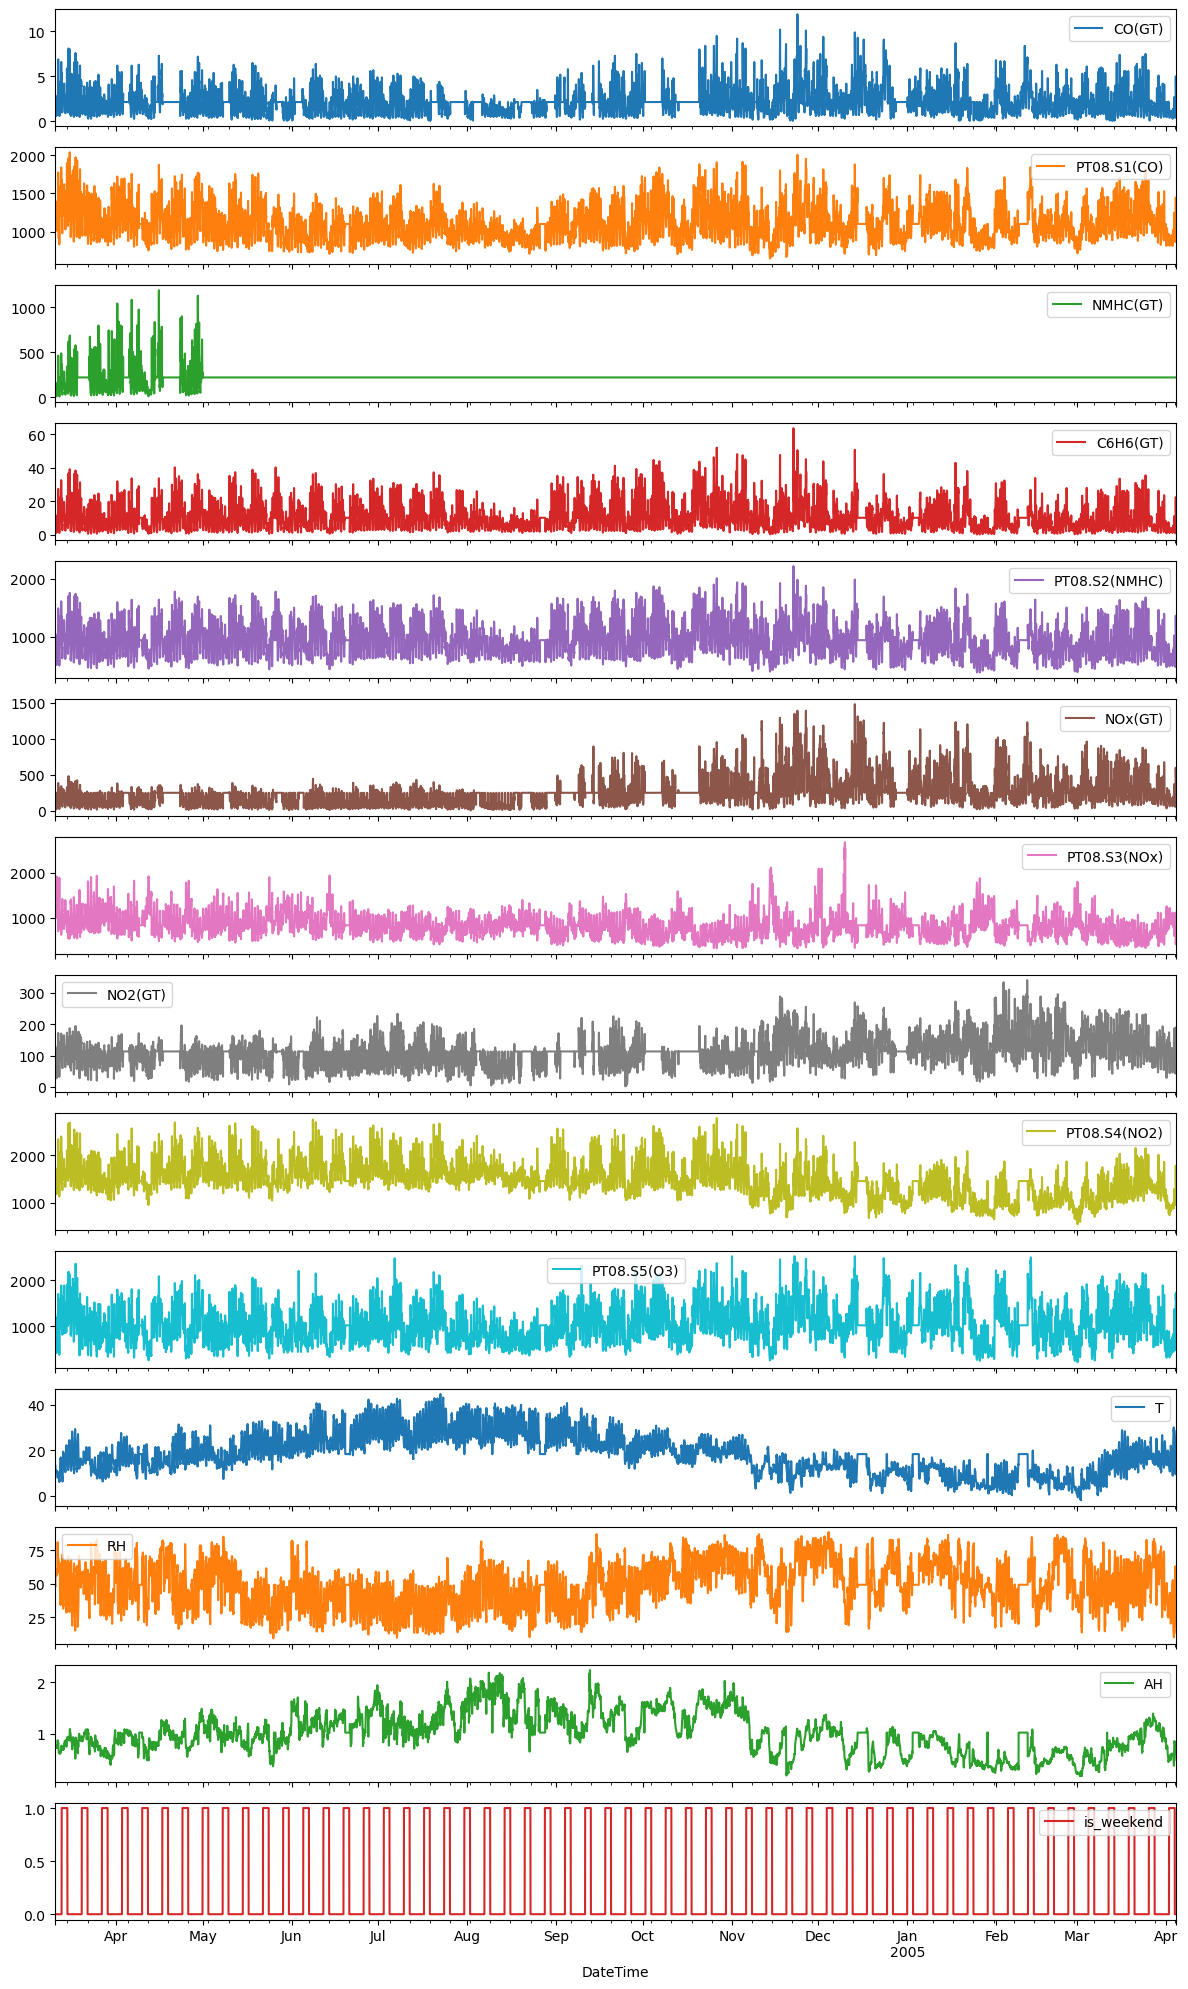

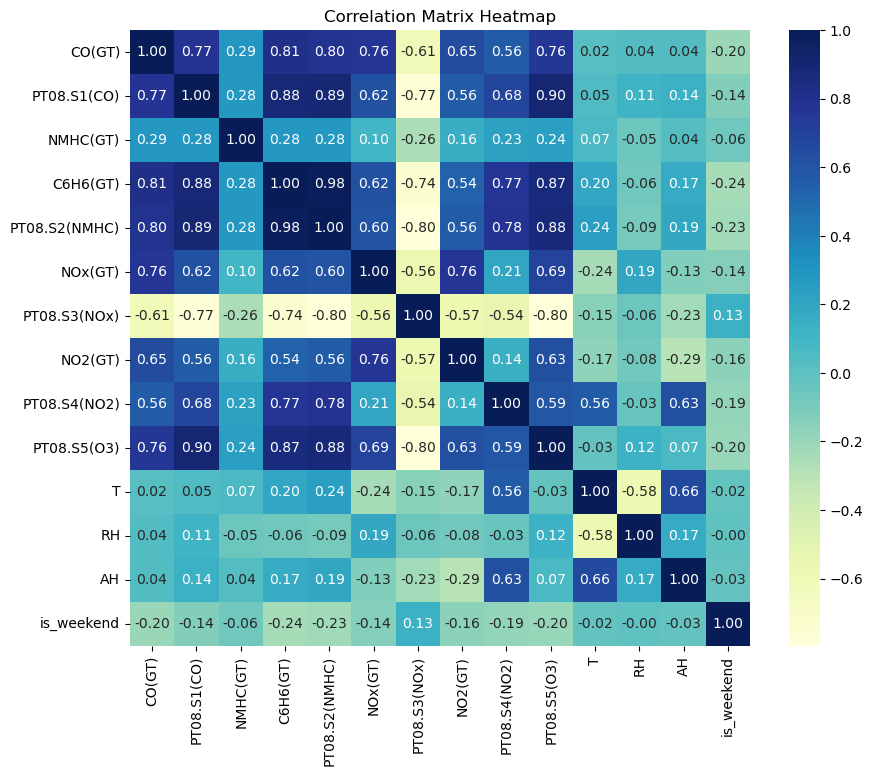

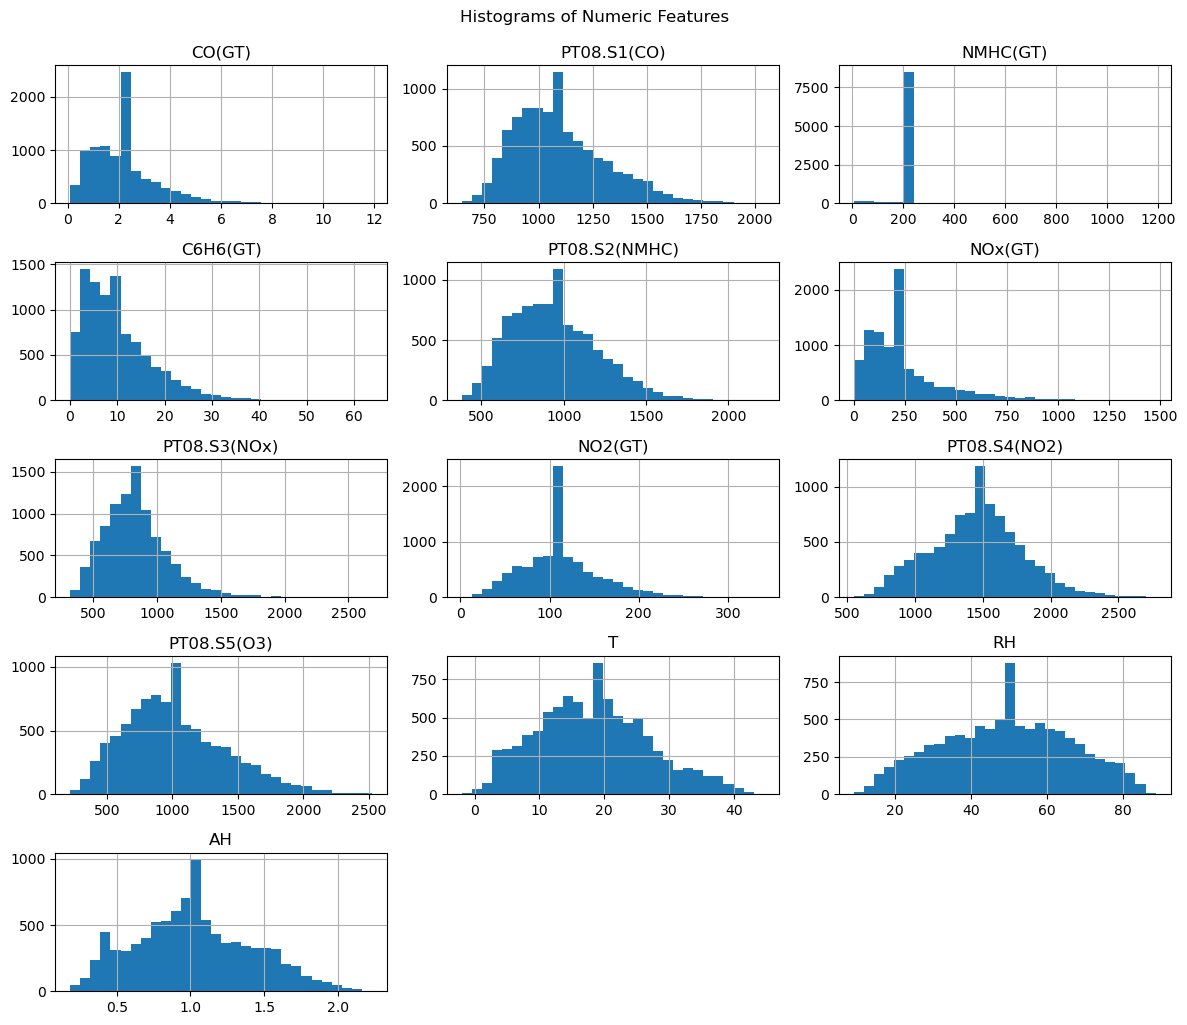

<Figure size 1200x600 with 0 Axes>

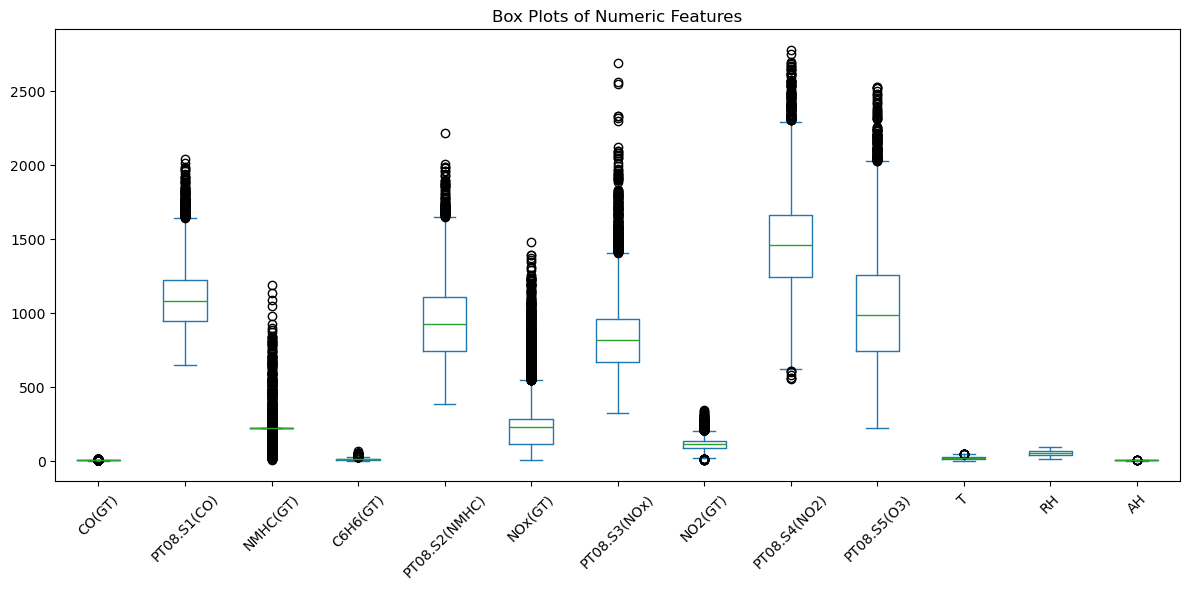

In [283]:
plt.figure(figsize = (12, 15))
df.plot(subplots = True, figsize = (12, 20), layout = (len(df.columns), 1), sharex = True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------

corr_matrix = df.corr()

plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot=True, cmap = 'YlGnBu', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

# ------------------------------------------------------------------------

df[numeric_cols].hist(bins=30, figsize = (12, 10), layout = (len(numeric_cols) // 3 + 1, 3))
plt.tight_layout()
plt.suptitle("Histograms of Numeric Features", y = 1.02)
plt.show()
# ------------------------------------------------------------------------

plt.figure(figsize = (12, 6))
df[numeric_cols].plot(kind='box', figsize = (12, 6))
plt.title("Box Plots of Numeric Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

5. Split the data into training, validation, and testing sets.

- The value of train size is 80% of the dataset
- The value of validation size is 10% of the dataset
- The value of test size is 10% of the dataset
- PT08.S2(NMHC) was defined as a target column.
- All other columns were used as input features

In [275]:
target_col = 'PT08.S2(NMHC)'
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].values
y = df[target_col].values
N = len(df)

train_size = int(N * 0.8)
val_size = int(N * 0.1)
test_size = N - train_size - val_size

train_X = X[:train_size]
train_y = y[:train_size]
val_X = X[train_size:train_size + val_size]
val_y = y[train_size:train_size + val_size]
test_X = X[train_size + val_size:]
test_y = y[train_size + val_size:]

5. Normalize or standardize your data using appropriate techniques.

- train_X_scaled = scaler_X.fit_transform(train_X) -> This calculates the mean and standard deviation from train_X and scales the training features.
- The same scaling was applied to validation and test features

In [276]:
scaler_X = StandardScaler()
train_X_scaled = scaler_X.fit_transform(train_X)
val_X_scaled   = scaler_X.transform(val_X)
test_X_scaled  = scaler_X.transform(test_X)

scaler_y = StandardScaler().fit(train_y.reshape(-1,1))
train_y_scaled = scaler_y.transform(train_y.reshape(-1,1)).flatten()
val_y_scaled   = scaler_y.transform(val_y.reshape(-1,1)).flatten()
test_y_scaled  = scaler_y.transform(test_y.reshape(-1,1)).flatten()

8. Sequence Creation:

- I declared create_sequences function depending on my LSTM structure. For each valid index i, it collects seq_length consecutive rows of features and the next targets.
- The sequence length is 40 which means the optimized length for the training process

In [277]:
def create_sequences(features, targets, seq_length = 24):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i : i + seq_length]
        y = targets[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 40
batch_size = 128

train_X_seq, train_y_seq = create_sequences(train_X_scaled, train_y_scaled, seq_length)
val_X_seq, val_y_seq = create_sequences(val_X_scaled, val_y_scaled, seq_length)
test_X_seq, test_y_seq = create_sequences(test_X_scaled, test_y_scaled, seq_length)

train_dataset = data_utils.TensorDataset(torch.tensor(train_X_seq, dtype = torch.float32), torch.tensor(train_y_seq, dtype = torch.float32).view(-1, 1))
val_dataset = data_utils.TensorDataset(torch.tensor(val_X_seq, dtype = torch.float32), torch.tensor(val_y_seq, dtype = torch.float32).view(-1, 1))
test_dataset = data_utils.TensorDataset(torch.tensor(test_X_seq, dtype = torch.float32),torch.tensor(test_y_seq, dtype =torch.float32).view(-1, 1))

train_loader = data_utils.DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
val_loader = data_utils.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = data_utils.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## Step 2: Model development

1. LSTM network for my time-series forecasting task.

- Bidirectional LSTM -> The LSTM outputs have size hidden_dim * 2. Because bidirectional is True.
- It uses a twolayer bidirectional LSTM to process input sequences. It takes the final time step's output and passes it through two fully connected layers with a Tanh activation and dropout
- Finally, I can see an individual output with a single value.

In [278]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim = 128, num_layers = 2, dropout=0.2):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = True
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size = hidden_dim,
            num_layers = num_layers,
            batch_first = True,
            dropout= dropout,
            bidirectional = self.bidirectional
        )
        
        factor = 2 if self.bidirectional else 1
        
        self.fc1 = nn.Linear(hidden_dim * factor, hidden_dim)
        self.activation = nn.Tanh()
        self.dropout_fc = nn.Dropout(p = dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        batch_size, _, _ = x.size()
        
        num_directions = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_dim, device = x.device)
        c0 = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_dim, device = x.device)      
        out, (_, _) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.activation(out)
        out = self.dropout_fc(out)
        out = self.fc2(out)
        
        return out


2. Process to train the model & Model summary & Applying tensorboard

- Evaluation Function -> This runs the model. It computes the MSE loss for every batch and collects the predicted and true values. I can get calculated regression metrics like MAE, RMSE, and R square.
- Traing and Testing -> The code sets hyperparameters to include hidden dimension, number of layers, dropout. After training, the best model is evaluated on the test set, and the test loss, MAE, RMSE, and R square are printed.
- Model summary -> The dummy input to matching the expected shape is created and passed to the summary function to suggest a summary of the final model architecture.
- I usually get R square value from 0.8 to 0.85

In [279]:
input_dim = train_X_seq.shape[2]
criterion = nn.MSELoss()

def evaluate(model, loader, criterion, scaler_y):
    model.eval()
    running_loss = 0.0
    total_samples = 0
    preds_list = []
    actual_list = []
    
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_loss += loss.item() * batch_X.size(0)
            total_samples += batch_X.size(0)
            preds_list.append(outputs.cpu().numpy())
            actual_list.append(batch_y.cpu().numpy())

    avg_loss = running_loss / total_samples
    preds = np.concatenate(preds_list).flatten()
    actuals = np.concatenate(actual_list).flatten()
    preds_inv = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
    actuals_inv = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()
    mae = mean_absolute_error(actuals_inv, preds_inv)
    rmse = np.sqrt(mean_squared_error(actuals_inv, preds_inv))
    r2 = r2_score(actuals_inv, preds_inv)
    
    return avg_loss, mae, rmse, r2

def train_and_evaluate(train_loader, val_loader, input_dim, hidden_dim, num_layers, dropout, lr, epochs, scaler_y):
    model = LSTM(input_dim, hidden_dim, num_layers, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr = lr, weight_decay = 1.5e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.5, patience = 3)
    writer = SummaryWriter(log_dir = "runs/air_quality_experiment")

    best_val_loss = float('inf')
    best_model_state = None
    train_loss_collection = []
    train_rmse_collection = []
    train_r2_collection = []
    val_rmse_collection = []
    val_loss_collection = []
    val_r2_collection = []


    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_X.size(0)
            total_train += batch_X.size(0)

        train_loss = running_loss / total_train
        train_loss, train_mae, train_rmse, train_r2 = evaluate(model, train_loader, criterion, scaler_y)
        val_loss, val_mae, val_rmse, val_r2 = evaluate(model, val_loader, criterion, scaler_y)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        train_loss_collection.append(train_loss)
        train_rmse_collection.append(train_rmse)
        train_r2_collection.append(train_r2)
        val_loss_collection.append(val_loss)
        val_rmse_collection.append(val_rmse)
        val_r2_collection.append(val_r2)

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", val_loss, epoch)
        writer.add_scalar("RMSE/Train", train_rmse, epoch)
        writer.add_scalar("RMSE/Validation", val_rmse, epoch)
        writer.add_scalar("R2/Train", train_r2, epoch)
        writer.add_scalar("R2/Validation", val_r2, epoch)
        

        print(f"Epoch {epoch} of {epochs} -> "f"Train Loss: {train_loss:.4f}, MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}, R²: {train_r2:.3f} | "
              f"Val Loss: {val_loss:.4f}, MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}, R²: {val_r2:.3f}")
        
    writer.flush()
    writer.close()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_loss_collection, train_rmse_collection, train_r2_collection, val_loss_collection, val_rmse_collection, val_r2_collection

hidden_dimension = 256
num_layers = 4
dropout = 0.4
learning_rate = 1.2e-3

result_model, train_loss_collection, train_rmse_collection, train_r2_collection, val_loss_collection, val_rmse_collection, val_r2_collection = train_and_evaluate(
    train_loader = train_loader,
    val_loader = val_loader,
    input_dim = train_X_seq.shape[2],
    hidden_dim = hidden_dimension,
    num_layers = num_layers,
    dropout = dropout,
    lr = learning_rate,
    epochs = 20,
    scaler_y=scaler_y
)

test_loss, test_mae, test_rmse, test_r2 = evaluate(result_model, test_loader, nn.MSELoss(), scaler_y)


print("\nTest Evaluation")
print(f"Test MAE: {test_mae:.2f}, Test RMSE: {test_rmse:.2f}, Test R square: {test_r2:.3f} Test Loss (MSE): {test_loss:.4f}")

# --------------------------------------------------------------------------------------------------------------------

dummy_input = torch.randn(32, train_X_seq.shape[1], train_X_seq.shape[2]).to(device)
summary(result_model, input_data = dummy_input)

Epoch 1 of 20 -> Train Loss: 0.3206, MAE: 109.11, RMSE: 147.38, R²: 0.679 | Val Loss: 0.4087, MAE: 126.14, RMSE: 166.41, R²: 0.543
Epoch 2 of 20 -> Train Loss: 0.2677, MAE: 104.22, RMSE: 134.67, R²: 0.732 | Val Loss: 0.2877, MAE: 104.75, RMSE: 139.61, R²: 0.678
Epoch 3 of 20 -> Train Loss: 0.2194, MAE: 91.59, RMSE: 121.92, R²: 0.780 | Val Loss: 0.2467, MAE: 95.57, RMSE: 129.28, R²: 0.724
Epoch 4 of 20 -> Train Loss: 0.2072, MAE: 90.18, RMSE: 118.49, R²: 0.793 | Val Loss: 0.2343, MAE: 91.11, RMSE: 125.99, R²: 0.738
Epoch 5 of 20 -> Train Loss: 0.1949, MAE: 84.88, RMSE: 114.91, R²: 0.805 | Val Loss: 0.2340, MAE: 92.07, RMSE: 125.90, R²: 0.738
Epoch 6 of 20 -> Train Loss: 0.2052, MAE: 85.47, RMSE: 117.92, R²: 0.795 | Val Loss: 0.2401, MAE: 91.86, RMSE: 127.54, R²: 0.731
Epoch 7 of 20 -> Train Loss: 0.1840, MAE: 83.13, RMSE: 111.66, R²: 0.816 | Val Loss: 0.2345, MAE: 89.98, RMSE: 126.05, R²: 0.738
Epoch 8 of 20 -> Train Loss: 0.1960, MAE: 85.43, RMSE: 115.23, R²: 0.804 | Val Loss: 0.2345, 

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [32, 1]                   --
├─LSTM: 1-1                              [32, 40, 512]             5,285,888
├─Linear: 1-2                            [32, 256]                 131,328
├─Tanh: 1-3                              [32, 256]                 --
├─Dropout: 1-4                           [32, 256]                 --
├─Linear: 1-5                            [32, 1]                   257
Total params: 5,417,473
Trainable params: 5,417,473
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 6.77
Input size (MB): 0.07
Forward/backward pass size (MB): 5.31
Params size (MB): 21.67
Estimated Total Size (MB): 27.05

3. Save the weights of the trained neural network that provides the best results.

In [280]:
torch.save(result_model.state_dict(), 'best_model_weights.pth')

## Step 3: Evaluation and analysis

1. Performance about the trained model on train and the validation set.

- Between Training and Validation Loss -> The green line to mean training loss fluctuate several times. It suggests the model is fitting the training set progressively. The pink line to mean validation loss also drops and fluctuates slightly. It indicats the model learns generalizable patterns. It finally converged into a specific value almost in the end 
- Between Training and Validation RMSE -> this has a similar tendency compared to the loss curves
- Between Training and Validation R square -> R square on the training set to mean green line consistently rises and fluctuates.

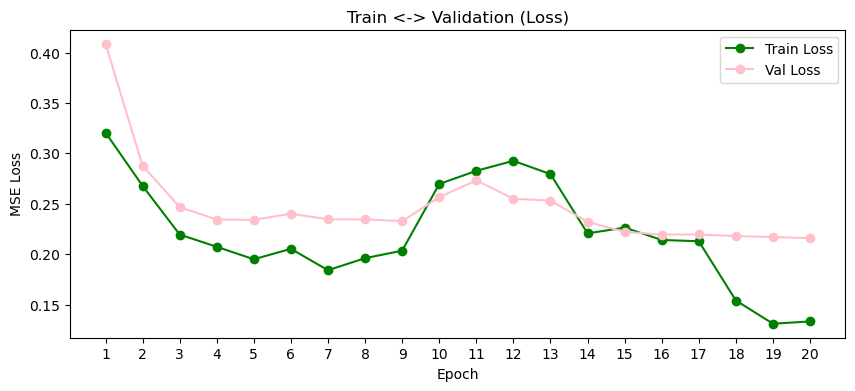

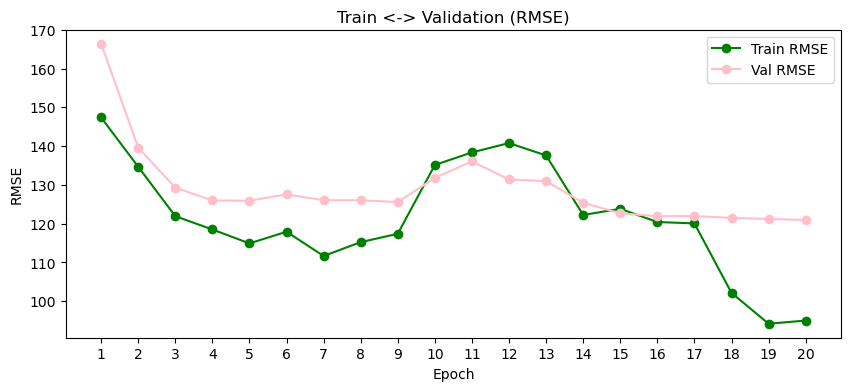

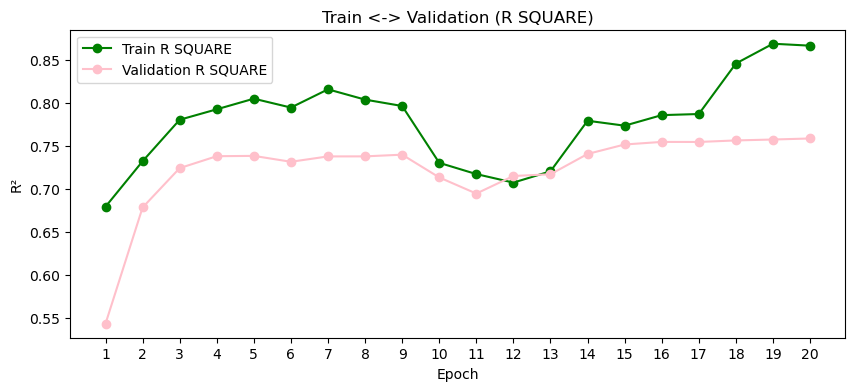

In [281]:
epochs_range = range(1, 21)

plt.figure(figsize=(10, 4))
plt.plot(epochs_range, train_loss_collection, label = 'Train Loss', color = 'green', marker = 'o')
plt.plot(epochs_range, val_loss_collection, label='Val Loss', color = 'pink', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Train <-> Validation (Loss)')
plt.legend()
plt.xticks(epochs_range)
plt.show()
# ------------------------------------------------------------------------------------


plt.figure(figsize=(10, 4))
plt.plot(epochs_range, train_rmse_collection, label='Train RMSE', color = 'green', marker = 'o')
plt.plot(epochs_range, val_rmse_collection, label='Val RMSE', color='pink', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Train <-> Validation (RMSE)')
plt.legend()
plt.xticks(epochs_range)
plt.show()

# ------------------------------------------------------------------------------------


plt.figure(figsize=(10, 4))
plt.plot(epochs_range, train_r2_collection, label = 'Train R SQUARE', color = 'green', marker = 'o')
plt.plot(epochs_range, val_r2_collection, label = 'Validation R SQUARE', color = 'pink', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Train <-> Validation (R SQUARE)')
plt.legend()
plt.xticks(epochs_range)
plt.show()


2. Relevant graphs for recognizing the performance of time series prediction

- Between Predicted and Actual based on time series plot -> I can see that the predicted curve generally follows the actual curve with.There are sometimes occasional offsets.
- Between Actual and Predicted based on scatter plot -> The tight clustering around the line suggests the model’s predictions correlate strongly with the actual values even if some scatter indicates errors or variance where the model could not captured.

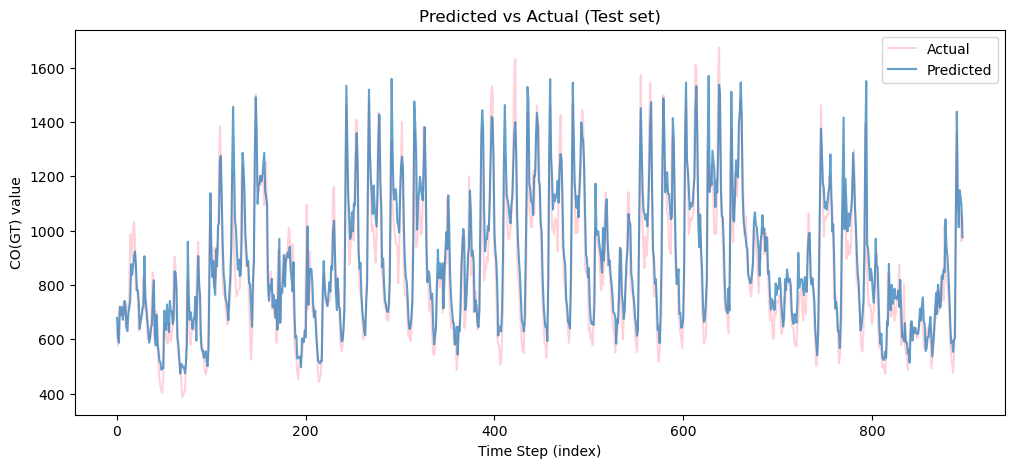

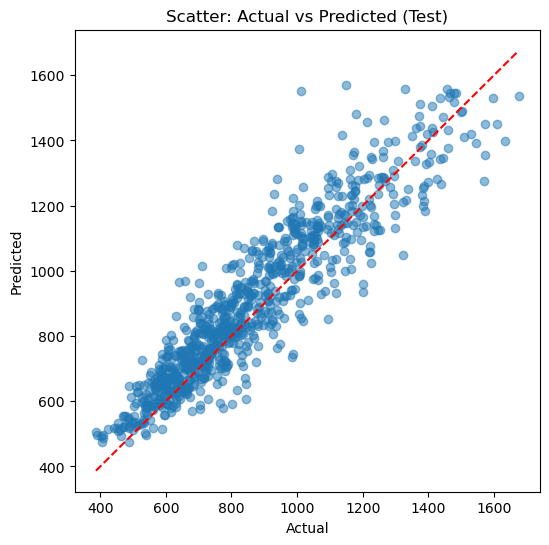

In [282]:
def predict_on_loader(model, loader, scaler_y):
    model.eval()
    preds_list = []
    actual_list = []

    with torch.no_grad():

        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            preds_list.append(outputs.cpu().numpy())
            actual_list.append(batch_y.cpu().numpy())
    predictions = np.concatenate(preds_list).flatten()
    actuals = np.concatenate(actual_list).flatten()
    preds_inv = scaler_y.inverse_transform(predictions.reshape(-1,1)).flatten()
    actuals_inv = scaler_y.inverse_transform(actuals.reshape(-1,1)).flatten()
    return actuals_inv, preds_inv

actuals_test, preds_test = predict_on_loader(result_model, test_loader, scaler_y)

plt.figure(figsize = (12,5))
plt.plot(actuals_test, label='Actual', alpha = 0.7, color = 'pink')
plt.plot(preds_test, label='Predicted', alpha = 0.7)
plt.title("Predicted vs Actual (Test set)")
plt.xlabel("Time Step (index)")
plt.ylabel("CO(GT) value")
plt.legend()
plt.show()

plt.figure(figsize = (6,6))
plt.scatter(actuals_test, preds_test, alpha = 0.5)
plt.title("Scatter: Actual vs Predicted (Test)")
plt.xlabel("Actual")
plt.ylabel("Predicted")

min_val = min(actuals_test.min(), preds_test.min())
max_val = max(actuals_test.max(), preds_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.show()


3. Discuss about overall process & Tensorboard

- The key characteristics -> I used all columns for the highest accuracy. All columns fluctuate depending on the day in plots
- Final RNN/LSTM architecture in detail -> - The LSTM outputs size will be hidden_dim * 2. Since bidirectional equals to True. Two layers are used for bidirectional LSTM to process input sequences. It gets the final time step's output and gives it through two fully connected layers with a Tanh activation and dropout. 
- The parameters are like next. It was defined after several training times -> hidden_dimension = 256 / num_layers = 4 / dropout = 0.4 / learning_rate = 1.2e-3
- I can usally get R square accuracy from 0.8 to 0.85. I added one more column for a higher accuracy. It was is_weekend. After adding the column, the performance became better. And, a few combinations of hidden_dimension, num_layers, dropout and learning_rate have been tried to get the best outcome.
- Limitation -> Loss and RMSE flucuate several times. This has to be fixed as the next step
- Future work -> I can try to merge other relevant datasets to current one. And, GRU for predicting can be applied after this time. This can lead to sophiscated preprocessing.


<img src="Loss_tensorboard.jpg" alt="Sample Image" width="1100">
<img src="R2_tensorboard.jpg" alt="Sample Image" width="1100">
<img src="RMSE_tensorboard.jpg" alt="Sample Image" width="1100">

4. References

- Wikipedia RNN, LSTM (https://en.wikipedia.org/wiki/Recurrent_neural_network)
- Stanford CS231N on Youtube(https://www.youtube.com/watch?v=6niqTuYFZLQ&t=3089s&ab_channel=StanfordUniversitySchoolofEngineering)
- MIT 6.S191 on Youtube(https://www.youtube.com/watch?v=ySEx_Bqxvvo&t=827s&ab_channel=AlexanderAmini)
- DeepLearning.ai RNN Basic (https://www.deeplearning.ai/the-batch/neural-networks-find-the-function/)